## Import Libraries

This step imports the necessary Python libraries for data manipulation, NLP, machine learning, and visualization.  Importing all libraries at the beginning makes the code organized and ensures that all required functions are available.

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel
import streamlit as st
from datasets import load_dataset

# Download NLTK resources (if not already downloaded)
nltk.download('stopwords')
nltk.download('punkt')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/homebrew/Cellar/python@3.9/3.9.22/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/homebrew/Cellar/python@3.9/3.9.22/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/in22417145/PycharmProjects/data-science-projects/dsvenv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance(

True

## Load the Dataset

This step loads the IMDB dataset using the Hugging Face _load_dataset_ function.  Hugging Face provides a convenient way to access and manage various datasets, including the IMDB dataset. We load both the training and testing splits.

In [2]:
train_df = pd.read_parquet('./data/train.parquet', engine='pyarrow')
test_df = pd.read_parquet('./data/test.parquet', engine='pyarrow')

In [3]:
# Rename the label column to 'sentiment'

train_df.rename(columns={'label': 'sentiment'}, inplace=True)
test_df.rename(columns={'label': 'sentiment'}, inplace=True)

In [4]:
print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 25000
Testing set size: 25000


##Data Preprocessing:

Text data requires cleaning and transformation before it can be used for machine learning. This step performs the following preprocessing steps:

- **Remove HTML Tags**: Movie reviews may contain HTML tags (e.g., <br />). These tags are removed using regular expressions to ensure that only the text content is retained.
- **Remove Special Characters and Numbers**: Special characters (except for apostrophes) and numbers are removed to reduce noise and focus on the essential words.
- **Convert to Lowercase**: Converting all text to lowercase ensures consistency and prevents the model from treating the same word differently based on its capitalization.
- **Remove Stopwords**: Stopwords (e.g., "the," "a," "is") are common words that do not carry significant meaning and can be removed to improve model performance.
- **Stemming**: Stemming reduces words to their root form (e.g., "running" to "run"). This helps to group related words together and reduce the dimensionality of the data.
- **Remove Extra Spaces**: Remove any extra spaces.

In [5]:
def preprocess_text(text):
    # 1. Remove HTML tags
    text = re.sub('<[^>]*>', '', text)
    # 2. Remove special characters and numbers (except apostrophes)
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    # 3. Convert to lowercase
    text = text.lower()
    # 4. Tokenize the text
    tokens = nltk.word_tokenize(text)
    # 5. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # 6. Apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # 7. Join the tokens back into a single string
    text = ' '.join(tokens)
    # 8. Remove extra spaces
    text = re.sub(' +', ' ', text)
    return text

In [6]:
# Apply preprocessing to the text column of both training and testing sets
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

print("Text preprocessing complete.")

Text preprocessing complete.


## Exploratory Data Analysis (EDA):

EDA involves analyzing the dataset to gain insights into its characteristics, identify patterns, and understand the distribution of the data.  For text data, EDA typically involves examining the length of reviews, the frequency of words, and the distribution of sentiment labels.  This step helps in understanding the nature of the data and can inform subsequent steps, such as feature engineering and model selection.

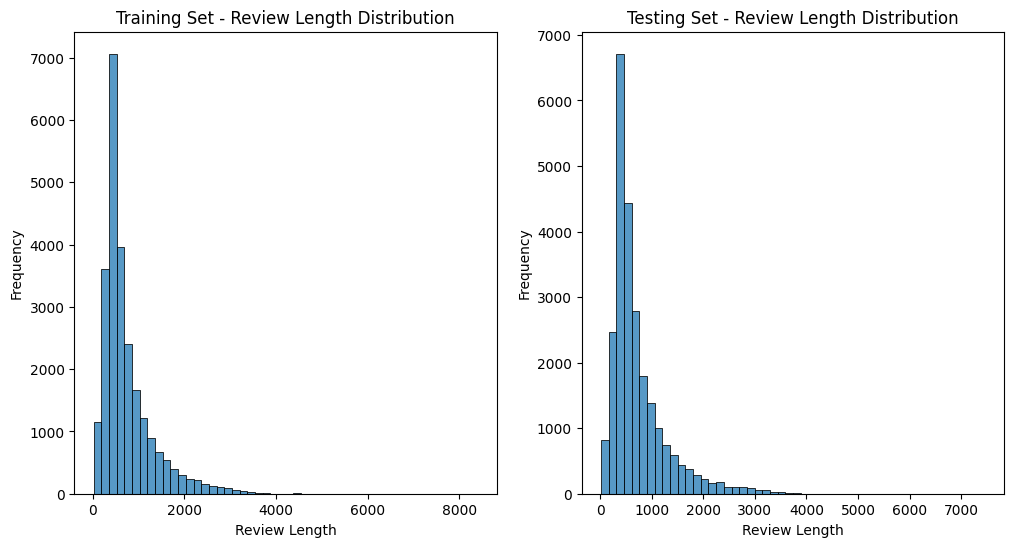

In [7]:
# Review Length Distribution
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_df['text_length'], bins=50)
plt.title('Training Set - Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test_df['text_length'], bins=50)
plt.title('Testing Set - Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

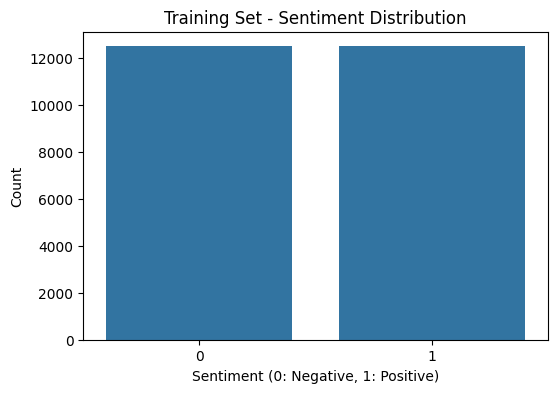

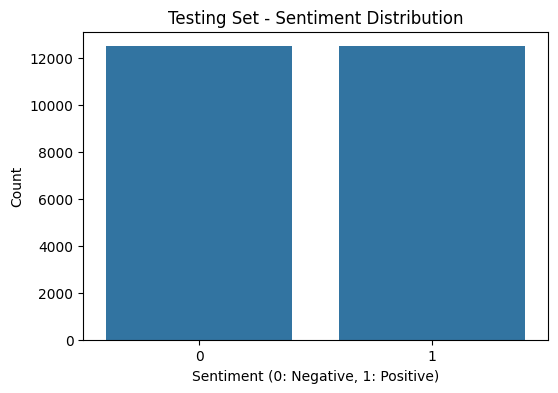

In [8]:
# Sentiment Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=train_df)
plt.title('Training Set - Sentiment Distribution')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=test_df)
plt.title('Testing Set - Sentiment Distribution')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

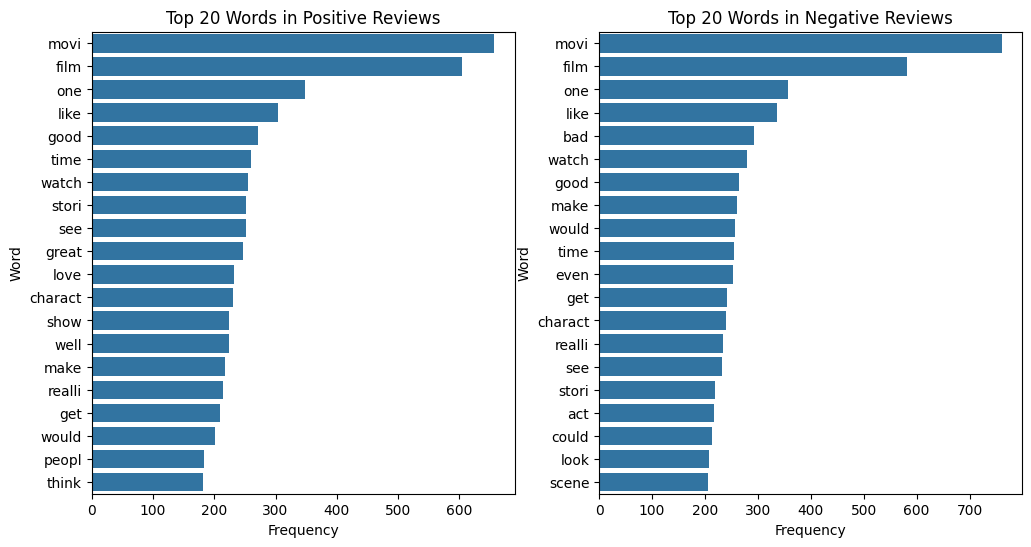

In [9]:
# Word Frequency Analysis (Top 20 words in positive and negative reviews)
from collections import Counter

def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

positive_reviews = train_df[train_df['sentiment'] == 1]['text']
negative_reviews = train_df[train_df['sentiment'] == 0]['text']

top_positive_words = get_top_n_words(positive_reviews, 20)
top_negative_words = get_top_n_words(negative_reviews, 20)

df_positive = pd.DataFrame(top_positive_words, columns=['Word', 'Frequency'])
df_negative = pd.DataFrame(top_negative_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Frequency', y='Word', data=df_positive)
plt.title('Top 20 Words in Positive Reviews')

plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Word', data=df_negative)
plt.title('Top 20 Words in Negative Reviews')
plt.show()

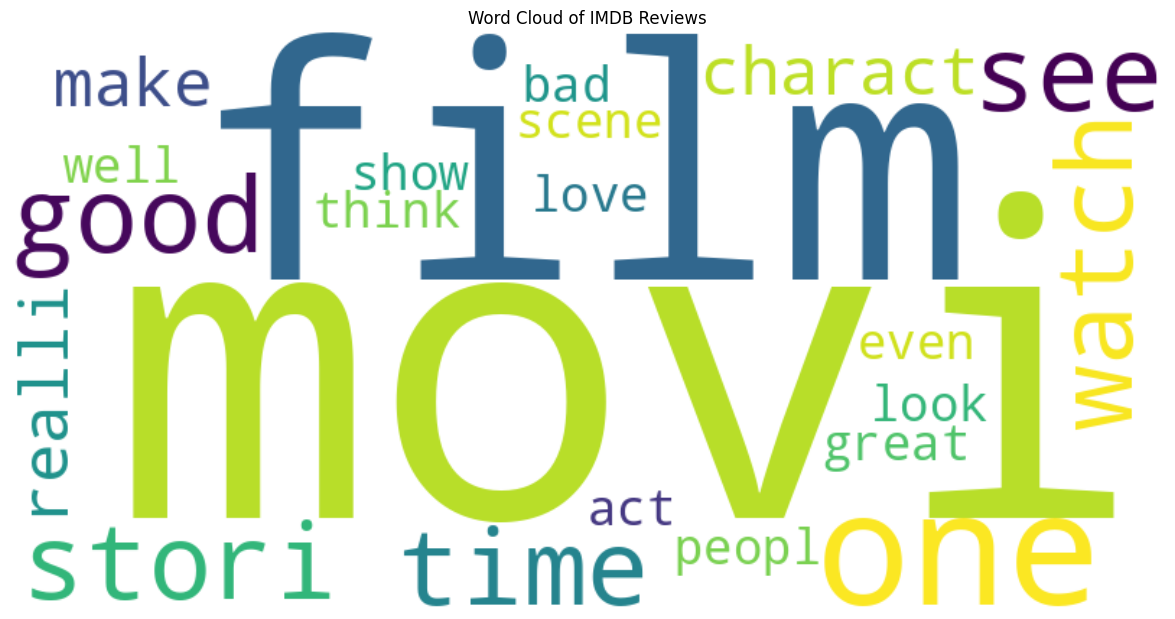

In [10]:
from wordcloud import WordCloud

# Generate word cloud by combining the top words from both positive and negative reviews
combined_words = ' '.join([word for word, freq in top_positive_words + top_negative_words])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_words)

# Display the word cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of IMDB Reviews')
plt.show()

### Insights from EDA:
- **Review Length**: The distribution of review lengths is right-skewed, indicating that most reviews are relatively short, with a few very long reviews.
- **Sentiment Balance**: The dataset is relatively balanced, with a roughly equal number of positive and negative reviews.
- **Word Frequency**: The most frequent words in positive and negative reviews provide insights into the language used to express sentiment. For example, positive reviews often contain words like "good," "great," and "best," while negative reviews may contain words like "bad," "worst," and "terrible."

## Feature Engineering:
- TF-IDF Vectorization - Machine learning models cannot directly process text data.  Feature engineering is the process of transforming text data into a numerical representation that the model can understand.  TF-IDF (Term Frequency-Inverse Document Frequency) is a popular technique for this purpose.
    - **Term Frequency (TF)**: Measures how often a word appears in a document.
    - **Inverse Document Frequency (IDF)**: Measures how rare a word is across the entire corpus.  Words that appear in many documents are considered less informative than words that appear in only a few documents.

TF-IDF assigns a weight to each word in a document based on its TF and IDF scores.  Words that are frequent in a specific document but rare in the overall corpus are given higher weights.  This helps the model to identify the words that are most relevant to the sentiment of a review.

    - TF-IDF captures the importance of words in a document relative to the entire corpus.
    - It reduces the impact of common words that do not contribute much to the meaning of the text.
    - It produces a numerical representation of the text, which can be used as input to machine learning models.


In [11]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) # Limiting features and us

In [12]:

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
y_train = train_df['sentiment']

In [13]:
# Transform the testing data
X_test = tfidf_vectorizer.transform(test_df['text'])
y_test = test_df['sentiment']

print("TF-IDF Vectorization complete.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

TF-IDF Vectorization complete.
Shape of X_train: (25000, 10000)
Shape of X_test: (25000, 10000)


## Model Selection:
- **Naive Bayes** - We'll start with a simple baseline model: Multinomial Naive Bayes.  Naive Bayes is a probabilistic classifier that is often used for text classification tasks.  It assumes that the features (word frequencies) are conditionally independent given the class (sentiment).  While this assumption is often violated in practice, Naive Bayes can still perform surprisingly well on text data.
    - It's computationally efficient, making it suitable for large datasets.
    - It performs well on text classification tasks, especially with TF-IDF features.
    - It provides a good baseline for comparison with more complex models.

In [14]:
# Train a Multinomial Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)

MultinomialNB()

In [15]:
# Make predictions on the test set
y_pred_nb = naive_bayes_classifier.predict(X_test)

In [16]:
# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8508
              precision    recall  f1-score   support

           0       0.85      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



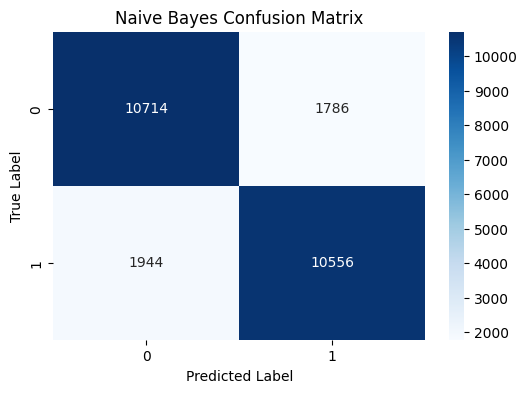

In [17]:
# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Model Selection: 
- **Deep Learning - LSTM**: We will now implement a more advanced model using deep learning with PyTorch.  Specifically, we'll use a Long Short-Term Memory (LSTM) network.  LSTMs are a type of recurrent neural network (RNN) that is well-suited for processing sequential data, such as text.  LSTMs are designed to handle the vanishing gradient problem, which can occur when training traditional RNNs on long sequences.
    - LSTMs can capture long-range dependencies in text, which are important for understanding sentiment.
    - They have been shown to achieve state-of-the-art results on various NLP tasks, including sentiment analysis.
    - PyTorch provides a flexible and powerful framework for building and training LSTMs.

Steps:
- **Tokenization and Padding**: Convert the text data into numerical sequences using a tokenizer.  Pad the sequences to a uniform length to be compatible with the LSTM model.
- **Create DataLoader**: Create PyTorch DataLoader to efficiently load the data in batches.
- **Define LSTM Model**: Define the LSTM architecture, including the embedding layer, LSTM layers, and output layer.
- **Train the Model**: Train the LSTM model using the training data and a suitable optimizer and loss function.
- **Evaluate the Model**: Evaluate the trained model on the test data.


In [18]:
# 1. Tokenization and Vocabulary Building
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

train_iter = train_df['text'].tolist()
test_iter = test_df['text'].tolist()

vocab = build_vocab_from_iterator(yield_tokens(train_iter),
                                min_freq=1,
                                specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

def text_pipeline(text):
    return vocab(tokenizer(text))

def pad_sequences_torch(sequences, max_len, padding_value=0):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_len:
            padded_sequences.append(torch.tensor(seq[:max_len]))
        else:
            padding = [padding_value] * (max_len - len(seq))
            padded_sequences.append(torch.tensor(seq + padding))
    return torch.stack(padded_sequences)

max_len = 200  # Maximum sequence length

X_train_seq = [text_pipeline(text) for text in train_df['text']]
X_test_seq = [text_pipeline(text) for text in test_df['text']]

X_train_padded = pad_sequences_torch(X_train_seq, max_len)
X_test_padded = pad_sequences_torch(X_test_seq, max_len)

max_words = len(vocab)  # Vocabulary size


In [19]:
# 2. Create DataLoader
batch_size = 64

class IMDBDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = IMDBDataset(X_train_padded, torch.tensor(y_train.values, dtype=torch.float))
test_dataset = IMDBDataset(X_test_padded, torch.tensor(y_test.values, dtype=torch.float))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# 3. Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_prob, pad_idx):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout_prob, batch_first=True)  # batch_first=True
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        # Use the output from the last time step
        last_output = output[:, -1, :]
        output = self.dropout(last_output)
        return self.fc(output).squeeze(1)

# Model parameters
embedding_dim = 100
hidden_dim = 256
output_dim = 1
num_layers = 2
dropout_prob = 0.5
pad_idx = vocab['<pad>']

# Initialize the model
model = LSTMModel(max_words, embedding_dim, hidden_dim, output_dim, num_layers, dropout_prob, pad_idx)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMModel(
  (embedding): Embedding(50669, 100, padding_idx=1)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [21]:
# 4. Train the Model
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        text, labels = batch
        text = text.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text = text.to(device)
            labels = labels.to(device)
            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Binary accuracy function
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Number of training epochs
num_epochs = 5
best_test_acc = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Epoch: {epoch+1:02} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_lstm_model.pt')  # Save the best model


Epoch: 01 | Train Loss: 0.694 | Train Acc: 50.31%
Epoch: 01 | Test Loss: 0.695 | Test Acc: 50.05%
Epoch: 02 | Train Loss: 0.694 | Train Acc: 50.23%
Epoch: 02 | Test Loss: 0.694 | Test Acc: 49.92%
Epoch: 03 | Train Loss: 0.693 | Train Acc: 50.26%
Epoch: 03 | Test Loss: 0.694 | Test Acc: 50.11%
Epoch: 04 | Train Loss: 0.693 | Train Acc: 50.68%
Epoch: 04 | Test Loss: 0.693 | Test Acc: 50.10%
Epoch: 05 | Train Loss: 0.690 | Train Acc: 51.89%
Epoch: 05 | Test Loss: 0.690 | Test Acc: 51.52%


In [ ]:

# 5. Evaluate the Model
# Load the best model
model.load_state_dict(torch.load('best_lstm_model.pt', map_location=device))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Best Test Loss: {test_loss:.3f} | Best Test Acc: {test_acc*100:.2f}%')

# Get predictions for the test set
model.eval()
y_pred_probs = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        text, labels = batch
        text = text.to(device)
        predictions = model(text)
        y_pred_probs.extend(torch.sigmoid(predictions).cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"LSTM Test Accuracy: {accuracy:.4f}")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm_lstm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = roc_auc_score(y_true, y_pred_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'LSTM ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC Curve')
plt.legend(loc='lower right')
plt.show()


1.  **Tokenization and Vocabulary Building:**
    *   `torchtext.vocab.build_vocab_from_iterator` is used to create a vocabulary from the training data. We iterate through the tokenized text and build the vocabulary, specifying a minimum frequency and special tokens like `<unk>` (unknown) and `<pad>` (padding).
    *   A `text_pipeline` function is defined to convert text into a sequence of indices based on the vocabulary.
    *   A custom `pad_sequences_torch` function is implemented using PyTorch's `torch.tensor` and `torch.stack` to pad sequences to a fixed length. We also handle truncation.
    *   `max_words` is now the size of the created vocabulary.

2.  **DataLoader:**
    *   The `IMDBDataset` class remains similar, but now it directly uses the PyTorch tensors created in the tokenization step.
    *   `torch.utils.data.DataLoader` is used for creating the data loaders.

3.  **LSTM Model:**
    *   The `LSTMModel` class is implemented using `torch.nn` modules:
        *   `nn.Embedding` for the embedding layer. We also set the `padding_idx` to the index of the `<pad>` token.
        *   `nn.LSTM` for the LSTM layer.
        *   `nn.Linear` for the fully connected output layer.
        *   `nn.Dropout` for dropout.
    *   The `forward` method remains similar, processing the embedded sequence through the LSTM and then the fully connected layer.

4.  **Training and Evaluation:**
    *   The `train` and `evaluate` functions are adapted to work with PyTorch tensors and the PyTorch optimizer (`torch.optim`).
    *   `torch.sigmoid` is used in the `binary_accuracy` function and during evaluation to get probabilities.
    *   `criterion` is set to `nn.BCEWithLogitsLoss()`, which combines a sigmoid layer and the binary cross-entropy loss in a numerically stable way.
    *   The training loop iterates through the `DataLoader`.
    *   `optimizer.zero_grad()`, `loss.backward()`, and `optimizer.step()` are used for the optimization process.
    *   Model saving and loading are done using `torch.save` and `torch.load`.

5.  **Evaluation Metrics:**
    *   The evaluation part remains largely the same, using `sklearn.metrics` for accuracy, classification report, confusion matrix, and ROC curve calculations. The predictions are converted to NumPy arrays after being passed through the sigmoid function.
    *   `matplotlib.pyplot` and `seaborn` are used for plotting the confusion matrix and ROC curve.